# Constitutive modelling using JuliaFEM

Author(s): Jukka Aho

**Abstract**: This is reproduction of the results from notebook [*Ideal plastic Von Mises material*](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/notebooks/2015-09-24-Ideal%20plastic%20Von%20Mises%20material.ipynb) made by Olli Väinölä. Small strain theory is used, see https://en.wikipedia.org/wiki/Flow_plasticity_theory. The purpose of this notebook is to show how one can easily design and simulate material models using JuliaFEM.

In [1]:
using JuliaFEM: IntegrationPoint, Field, FieldSet, TimeStep, Increment
using ForwardDiff
using PyPlot

The atomic structure here is `IntegrationPoint`. It has identical `Field`-structure like elements and can store multidimensional variables which can be time-dependent also. That way one can easily store, for example, measured strain and easily run material simulation for measured data.

In [2]:
ip = IntegrationPoint([0.0, 0.0], 1.0)

ip.fields["total strain"] = Field()
ip.fields["plastic strain"] = Field()
ip.fields["plastic potential"] = Field()
ip.fields["elastic strain"] = Field()
ip.fields["effective plastic strain"] = Field()
ip.fields["stress"] = Field()
ip.fields["young"] = Field(200.0e9)
ip.fields["poisson"] = Field(0.3)
ip.fields["yield stress"] = Field(200.0e6)
ip.fields["plastic rate parameter"] = Field(0.0) # material parameter

JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,JuliaFEM.Increment[[0.0]])])

Accessing parameters is done just like with `FieldSet`s in general:

In [3]:
info(last(ip.fields["young"]))
info(last(ip.fields["yield stress"]))

INFO: [2.0e11]
INFO: [2.0e8]


Our material model is

In [118]:
""" Ideal plastic material model. """
function calculate_stress!(ip::IntegrationPoint, strain::Matrix, time::Number)

    dim = size(strain, 1)
    
    poisson = last(ip.fields["poisson"])[1]
    young = last(ip.fields["young"])[1]
    mu = young/(2*(1+poisson))
    lambda = young*poisson/((1+poisson)*(1-2*poisson))
    if dim == 2
        lambda = 2*lambda*mu/(lambda + 2*mu)  # <- correction for 2d
    end

    # yield function
    function f(stress)
        # https://en.wikipedia.org/wiki/Yield_surface
        # https://en.wikipedia.org/wiki/Von_Mises_yield_criterion
        #s = stress - 1/dim*trace(stress)*I  # deviatoric stress tensor
        #J2 = 1/2*trace(s*s')
        #stress_v = sqrt(3/2*trace(s*s')) # equivalent tensile stress
        stress_y = last(ip.fields["yield stress"])[1]
        #k = stress_y/sqrt(2)
        #return J2 - k^2
        s1 = stress[1,1]
        s2 = stress[2,2]
        s12 = stress[1,2]
        stress_v = sqrt(s1^2 - s1*s2 + s2^2 + 3*s12^2)
        #s1, s2 = eigvals(stress)
        #stress_v = sqrt(s1^2 + s2^2 - s1*s2)
        return stress_v - stress_y
    end

    stress_trial = lambda*trace(strain)*I + 2*mu*strain

    if f(stress_trial) <= 0.0
        info("time=$time: no yield")
        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress_trial])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
        return true
    else
        info("time=$time: yield, f(stress_trial) = $(f(stress_trial))")
        dt = time - ip.fields["total strain"][end].time

        # associated flow rule, plastic potential ψ(σ) = f
        psi = f

        """ Calculate equations

            dσ - C (dϵₜ - dγ*dΨ/dσ) = 0
                         σₑ(σ) - σy = 0

            dϵₜ = total strain
            dϵₑ = elastic strain
            dϵₚ = plastic strain
        
            dϵₜ = dϵₑ + dϵₚ
            => dϵₑ = dϵₜ - dϵₚ = dϵₜ - dγ*dψ/dσ
            dσ = λ⋅tr(dϵₑ)I + 2μ⋅dϵₑ
            => dσ - λ⋅tr(dϵₑ)I - 2μ⋅dϵₑ = 0
        """
        function residual(params::Vector)
            dstress = reshape(params[1:prod(size(strain))], size(strain))
            gamma = params[end]

            strain_prev = last(ip.fields["total strain"])[1]
            stress_prev = last(ip.fields["stress"])[1]

            dstrain_total = 1/dt*(strain - strain_prev)
            #dstress = 1/dt*(stress - stress_prev)
            #dstress = 1/dt*(stress_trial - stress)
            stress_tot = stress_prev + dstress
            # derivative of plastic potential ψ(σ) w.r.t 2nd order tensor σ(ϵ)
            # https://en.wikipedia.org/wiki/Tensor_derivative_%28continuum_mechanics%29
            # "Derivatives of scalar valued functions of second-order tensors"
            dpsi_dstress = derivative(psi, stress_tot)
            dstrain_plastic = gamma*dpsi_dstress
            dstrain_elastic = dstrain_total - dstrain_plastic
            dstress_elastic = lambda*trace(dstrain_elastic)*I + 2*mu*dstrain_elastic

            stress_delta = dstress - dstress_elastic
            return [vec(stress_delta); psi(stress_tot)]
        end

        
        # solve equations using Newton iterations. Jacobian is calcualated
        # using automatic differentiation as usual.
        stress_prev = last(ip.fields["stress"])[1]
        #initial_stress = last(ip.fields["stress"])[1]
        #initial_gamma = last(ip.fields["plastic rate parameter"])[1]
        initial_gamma = 0.0
        params = [vec(stress_prev); initial_gamma]
        #info("initial params = $params")
        dparams = zeros(5)
        l = [1, 4, 3, 5]
        #l = [1, 2, 3, 4, 5]
        for i=1:20
            A = ForwardDiff.jacobian(residual, params)[l,l]
            b = -residual(params)[l]
            dparams = A \ b
            params[l] += dparams
            solution_norm = norm(dparams)
            if solution_norm < 1.0e-7
                info("norm = $solution_norm")
                break
            end
        end
        params[2] = params[3]
        #info("params = $params")
        dstress = reshape(params[1:prod(size(strain))], size(strain))
        stress = stress_prev + dstress
        #info("f(stress) = $(f(stress)), dstress = $(vec(dstress))")
        push!(ip.fields["stress"], TimeStep(time, Increment(Matrix[stress])))
        push!(ip.fields["total strain"], TimeStep(time, Increment(Matrix[strain])))
        #push!(ip.fields["plastic rate parameter"], TimeStep(time, Increment(params[end])))
    end

end    ### END OF CONSTITUTIVE MODEL

calculate_stress! (generic function with 1 method)

Small "simulator" to study the behavior of material model in `IntegrationPoint`

In [119]:
function run(steps=50)

    # initialization
    ip = IntegrationPoint([0.0, 0.0], 1.0)
    ip.fields["total strain"] = Field()
    ip.fields["plastic strain"] = Field()
    ip.fields["plastic potential"] = Field()
    ip.fields["elastic strain"] = Field()
    ip.fields["effective plastic strain"] = Field()
    ip.fields["stress"] = Field()
    ip.fields["young"] = Field(200.0e9)
    ip.fields["poisson"] = Field(0.3)
    ip.fields["yield stress"] = Field(200.0e6)
    ip.fields["plastic rate parameter"] = Field() # material parameter

    # run
    for (time, strain_11) in enumerate(linspace(0, 200e-5, steps))
        # set up strain etc.
        time = Float64(time)
        poisson = last(ip.fields["poisson"])[1]
        strain = zeros(2, 2)
        strain[1, 1] = strain_11
        strain[2, 2] = -poisson*strain_11
        #strain[2, 2] = strain_11
        strain[1, 2] = 1/3*strain_11
        strain[2, 1] = 1/3*strain_11

        # calculate stress
        calculate_stress!(ip, strain, time)
    end

    return ip
end

ip = run();

INFO: time=1.0: no yield
INFO: time=2.0: no yield
INFO: time=3.0: no yield
INFO: time=4.0: no yield
INFO: time=5.0: no yield
INFO: time=6.0: no yield
INFO: time=7.0: no yield
INFO: time=8.0: no yield
INFO: time=9.0: no yield
INFO: time=10.0: no yield
INFO: time=11.0: no yield
INFO: time=12.0: no yield
INFO: time=13.0: no yield
INFO: time=14.0: no yield
INFO: time=15.0: no yield
INFO: time=16.0: no yield
INFO: time=17.0: no yield
INFO: time=18.0: no yield
INFO: time=19.0: no yield
INFO: time=20.0: no yield
INFO: time=21.0: no yield
INFO: time=22.0: no yield
INFO: time=23.0: no yield
INFO: time=24.0: yield, f(stress_trial) = 5.438631395957261e6
INFO: norm = 6.327290296460759e-10
INFO: time=25.0: yield, f(stress_trial) = 1.4370745804477155e7
INFO: norm = 2.5368436951508793e-10
INFO: time=26.0: yield, f(stress_trial) = 2.330286021299705e7
INFO: norm = 2.1402519744192276e-10
INFO: time=27.0: yield, f(stress_trial) = 3.2234974621516943e7
INFO: norm = 9.421226040685514e-10
INFO: time=28.0: yi

Visualize results:

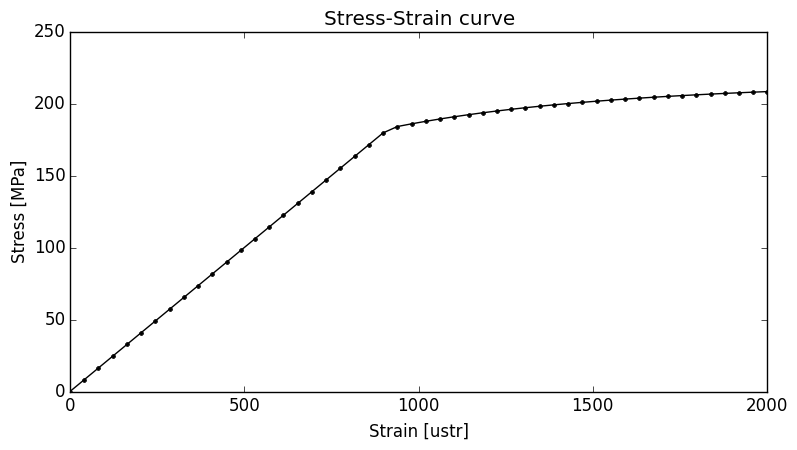

(0,250)

In [120]:
steps = length(ip.fields["total strain"])
eps11 = Float64[]
sig11 = Float64[]
principals = Vector{Float64}[]
for i=1:steps
    # extract from integration points -- too complicated
    # field -> timestep -> increment -> (vector of tensors, take first) -> (first component)
    strain = ip.fields["total strain"][i][end][1]*1.0e6
    stress = ip.fields["stress"][i][end][1]*1.0e-6
    push!(eps11, strain[1,1])
    push!(sig11, stress[1,1])
    push!(principals, sort(eigvals(stress)))
end

#PyPlot.figure(figsize=(7, 5))
PyPlot.plot(eps11, sig11, "-k.")
PyPlot.title("Stress-Strain curve")
PyPlot.xlabel("Strain [ustr]")
PyPlot.ylabel("Stress [MPa]")
PyPlot.ylim([0, 250])

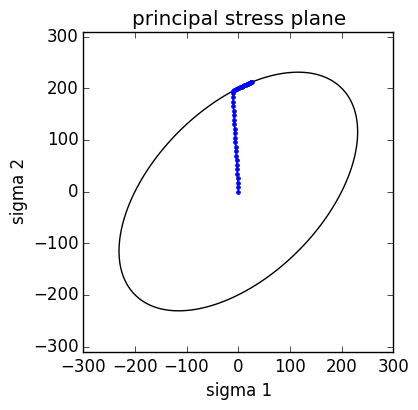

PyObject <matplotlib.text.Text object at 0x7ff7c44a5b90>

In [121]:
function plot_principal()
    PyPlot.figure(figsize=(4, 4))
    n = 100
    s = linspace(-300, 300, n)
    s1 = repmat(s', n, 1)
    s2 = repmat(s, 1, n)
    sigma = sqrt(s1.^2 + s2.^2 - s1.*s2)
    contour(s1, s2, sigma, [200], colors="k")
    p1 = [p[1] for p in principals]
    p2 = [p[2] for p in principals]
    PyPlot.plot(p1, p2, "-b.")
    axis("equal")
    xlabel("sigma 1")
    ylabel("sigma 2")
    title("principal stress plane")
end
plot_principal()